In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import cv2

In [2]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def load_image(image_path):
    img = cv2.imread(image_path)
    return img

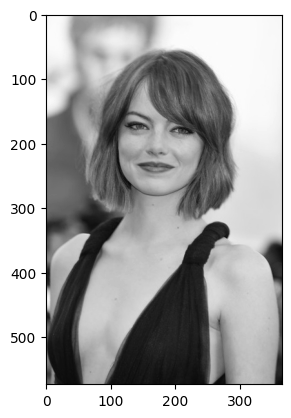

In [7]:
img = load_image('../EdgeBasedSegmentation/faces_imgs/4.jpg')
gray = rgb2gray(img)   
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

In [46]:
from scipy import ndimage
from scipy.ndimage import convolve

from scipy import misc

In [47]:
class cannyEdgeDetector:
    def __init__(self, img, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.img = img
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
    
    def gaussian_kernel(self, size, sigma=1):
        ax = np.linspace(-(size // 2), size // 2, size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel / np.sum(kernel)
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        gaussian_k = self.gaussian_kernel(self.kernel_size, self.sigma)
        self.img_smoothed = convolve(self.img, gaussian_k)

        self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)

        self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)

        self.thresholdImg = self.threshold(self.nonMaxImg)

        img_final = self.hysteresis(self.thresholdImg)


        return img_final.astype(np.uint8)

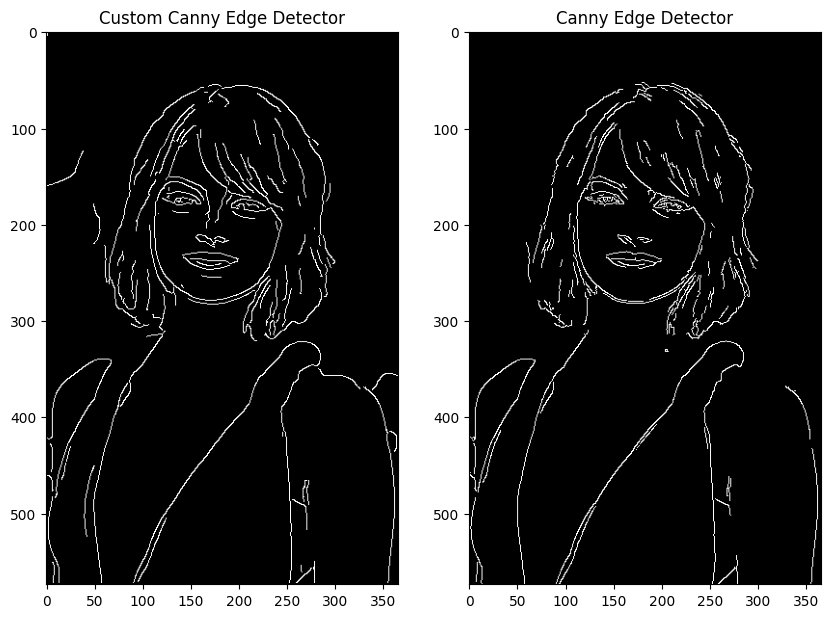

In [48]:
detector = cannyEdgeDetector(gray, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)
img_final = detector.detect()

gray_uint8 = np.uint8(gray)
detector_canny = cv2.Canny(gray_uint8, 100, 200)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title('Custom Canny Edge Detector')
axs[1].set_title('Canny Edge Detector')
axs[0].imshow(img_final, cmap = plt.get_cmap('gray'))
axs[1].imshow(detector_canny, cmap = plt.get_cmap('gray'))
plt.show()

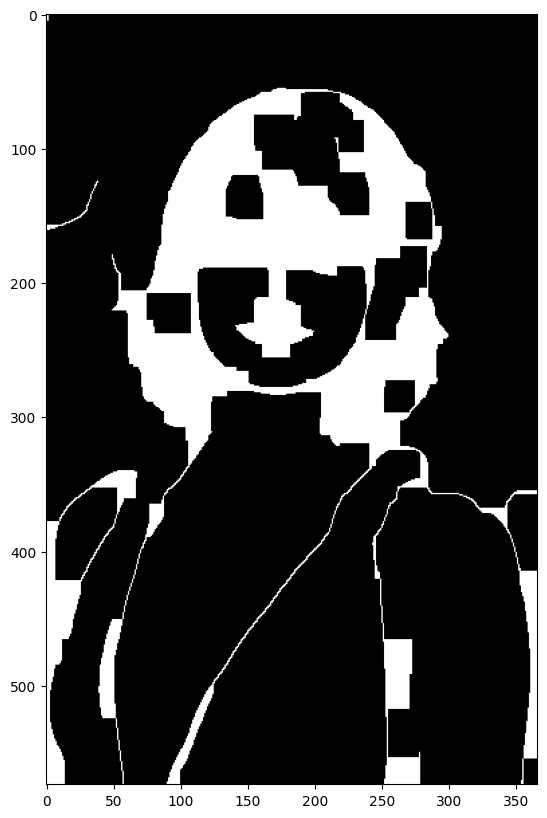

In [49]:
# Áp dụng phép toán hình thái học để đóng các lỗ hổng trong cạnh
img_watershed = img_final.copy()
# img_watershed = detector_canny.copy()
kernel = np.ones((7,7), np.uint8)  
closing = cv2.morphologyEx(img_watershed, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.figure(figsize=(10, 10))
plt.imshow(closing, cmap = plt.get_cmap('gray'))
plt.show()

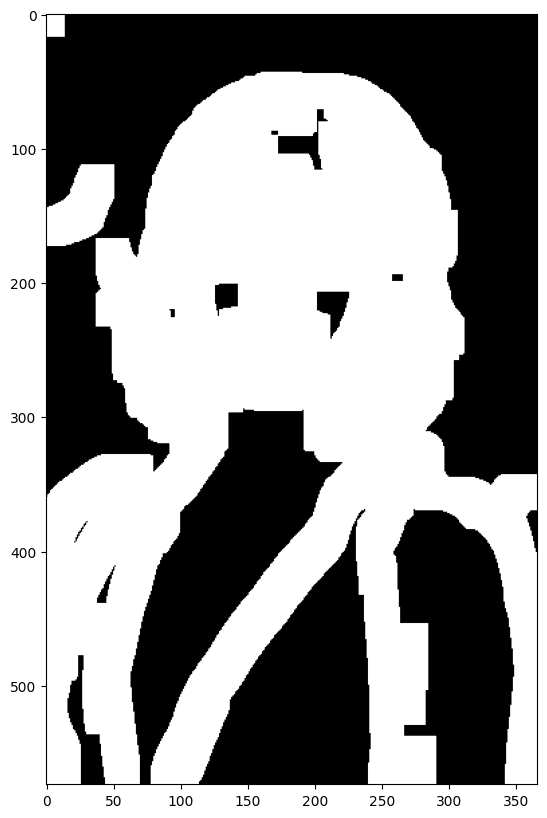

In [50]:
# Tìm các vùng chắc chắn (background)
sure_bg = cv2.dilate(closing, kernel, iterations=4)
plt.figure(figsize=(10, 10))
plt.imshow(sure_bg, cmap = plt.get_cmap('gray'))
plt.show()

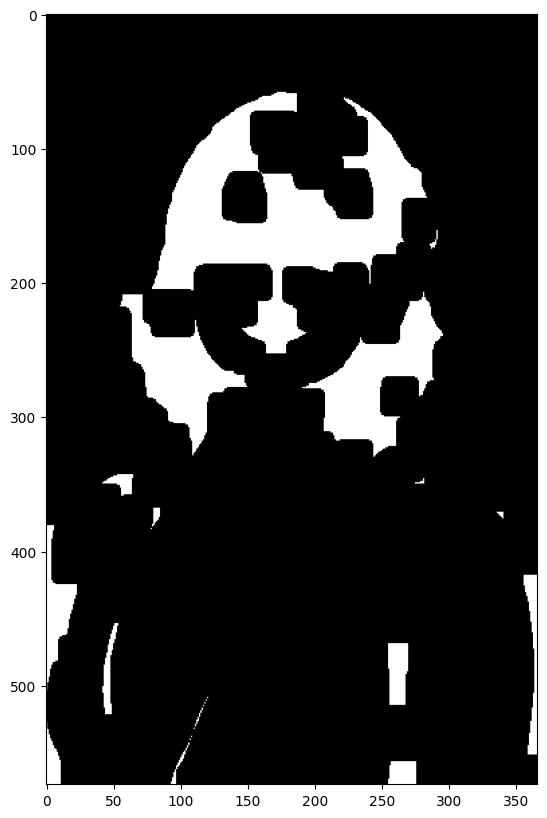

In [51]:
# Tìm các vùng chắc chắn (foreground) bằng cách sử dụng distance transform
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
plt.figure(figsize=(10, 10))
plt.imshow(sure_fg, cmap = plt.get_cmap('gray'))
plt.show()

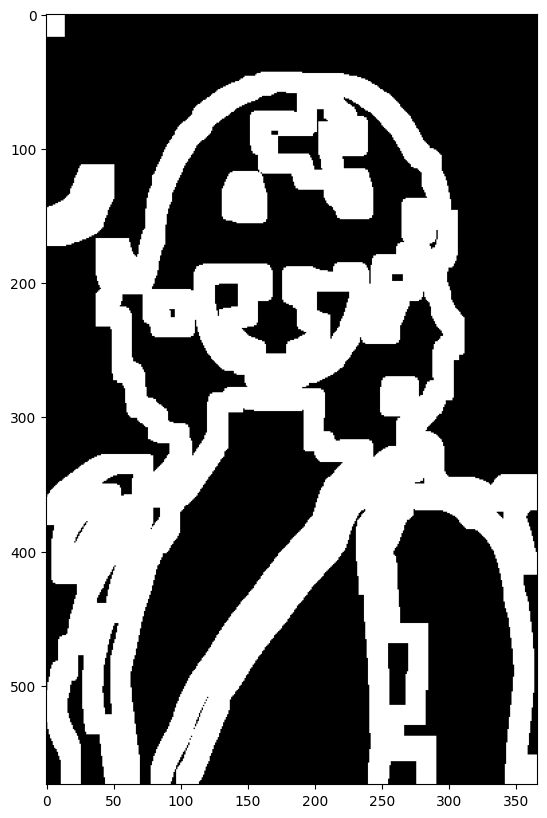

In [52]:
# Tìm các vùng không chắc chắn
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.figure(figsize=(10, 10))
plt.imshow(unknown, cmap = plt.get_cmap('gray'))
plt.show()

In [53]:
# img_copy = img.copy()

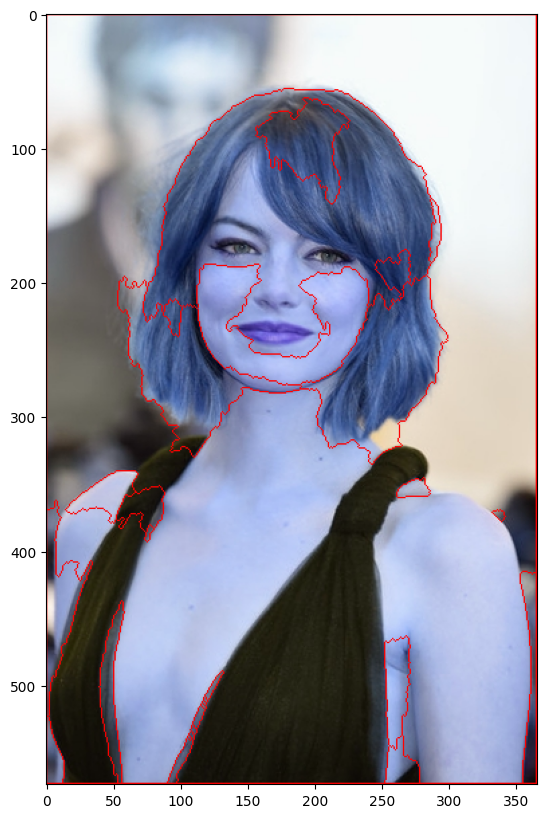

In [54]:
# Đánh dấu các nhãn cho thuật toán Watershed
ret, markers = cv2.connectedComponents(sure_fg)

# Tăng giá trị nhãn để đảm bảo nhãn nền là không phải 0
markers = markers + 1

# Đánh dấu vùng không chắc chắn bằng 0
markers[unknown == 255] = 0

# Áp dụng thuật toán Watershed
markers = cv2.watershed(img, markers)

# Đánh dấu biên bằng màu đỏ
img[markers == -1] = [255, 0, 0]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [55]:
segmented_image = np.zeros_like(img)
for marker in np.unique(markers):
    if marker == -1 or marker == 1:
        continue
    segmented_image[markers == marker] = np.random.randint(0, 255, 3)

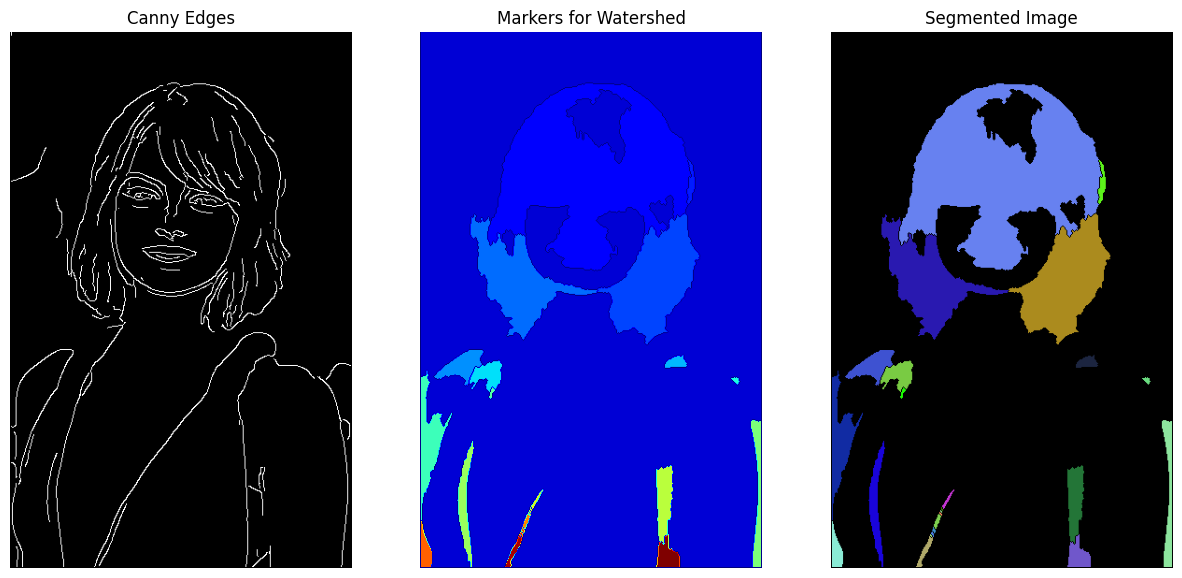

In [56]:
# Hiển thị kết quả
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(img_final, cmap='gray')
axs[0].set_title('Canny Edges')
axs[0].axis('off')

axs[1].imshow(markers, cmap='jet')
axs[1].set_title('Markers for Watershed')
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axs[2].set_title('Segmented Image')
axs[2].axis('off')

plt.show()